In [13]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from sklearn import linear_model
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
import seaborn as sns; sns.set()
import time 
import math
from sklearn.decomposition import PCA, FastICA
import os
import turchin
from multiprocessing import Pool, Process

In [14]:
# read csv/excel data files 
dataPath = os.path.abspath(os.path.join("./..","data","pnas_data1.csv"))
pnas_data1 = pd.read_csv(dataPath)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
times = pnas_data1.loc[:, ['Time']].values
ngas = pnas_data1.NGA.unique().tolist()
P, D, Q = turchin.svd(data_mat)
data = np.matmul(data_mat, Q.T)

In [5]:
# angle between vectors and various measurements for errors 

def angle(vec1, vec2):
    """
    Given two vectors, compute the angle between the vectors
    """
    assert vec1.shape == vec2.shape
    
    cos_vec = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    angle = math.acos(cos_vec)
    in_deg = math.degrees(angle)
    if in_deg >= 90:
        return (180-in_deg)
    return in_deg

def angle_error(ang1, ang2):
    """
    Given two angles, compute the relative error
    """
    if ang1 >= 90 and ang2 < 90:
        return abs((180-ang1)-ang2)/(180-ang1)
    elif ang1 < 90 and ang2 >= 90:
        return abs(ang1-(180-ang2))/(ang1)
    elif ang1 >= 90 and ang2 >= 90:
        return abs((180-ang1)-(180-ang2))/(180-ang1)
    else:
        return abs(ang1-ang2)/ang1

def vec_error(original, bst):
    """
    Given two n-dim vectors, one from the original and one from bootstrapping, compute the relative error
    between these two vectors
    """
    assert original.shape == bst.shape 
    
    return np.linalg.norm(original-bst)/np.linalg.norm(original)

def error(val1, val2):
    """
    Given two values, compute the relative error
    """
    return abs(val1-val2)/val1


In [6]:
#eigenvalues and eigenvectors for covariance matrix. Determine which of the two components they belong to by 
#the weights of the gaussians

def eig(mat):
    """
    Given a list of two matrices, compute the largest eigenvalues' proportion over sum of all eigenvalues as well 
    as the corresponding eigenvectors
    """
    eig_val1, eig_vec1 = np.linalg.eig(mat[0])
    eig_val2, eig_vec2 = np.linalg.eig(mat[1])
    
    assert eig_vec1.shape == eig_vec2.shape
    assert len(eig_val1) == len(eig_val2)
    
    # proportion of largest eigenvalue with respect to each component
    val1 = max(eig_val1)/sum(eig_val1)
    val2 = max(eig_val2)/sum(eig_val2)
    
    # eigenvector corresponding to the largest eigenvalue with respect to each component
    vec1 = eig_vec1[:,np.argmax(eig_val1)]
    vec2 = eig_vec2[:,np.argmax(eig_val2)]
    
    assert vec1.shape == vec2.shape
    
    return val1, val2, vec1, vec2

def dist(vec1, vec2):
    """
    Euclidean distance between two vectors
    """
    return np.linalg.norm(vec1-vec2)

def mahalanobis(vec, mean, cov):
    """
    Compute the mahalanobis distance of the given vector, vec
    """
    subtracted = np.subtract(vec, mean)
    return math.sqrt(np.matmul(np.matmul(subtracted.T, np.linalg.inv(cov)),subtracted))

def weight_set(means, weights, bstr_means, cov_mat, bstr=False):
    """
    Given gmm model, set the component with larger weight to be the first component and the component with
    smaller weight to be the second component
    """
    
    val1, val2, vec1, vec2 = eig(cov_mat) #eigenvalues and eigenvecotrs for covariance matrices
    
    # designate the larger component to be the component1 and the smaller component the component2 
    
    if bstr: 
        if weights[0] > weights[1]:
            mean1 = means[0]
            mean2 = means[1]
        else:
            mean1 = means[1]
            mean2 = means[0]

        if mahalanobis(bstr_means[0], mean1, cov_mat[0]) < mahalanobis(bstr_means[1], mean1, cov_mat[1]):
            return val1, val2, vec1, vec2
        else:
            return val2, val1, vec2, vec1
    else:
        if weights[0] > weights[1]:
            return val1, val2, vec1, vec2
        else:
            return val2, val1, vec2, vec1


# Bootstrapping on the percentage of the largest eigenvalue (over the sum of all eigenvalues) for each of the two Gaussians, as well as on the angle between the two main eigenvectors for each of the two Gaussians (where each of these two eigenvectors corresponds to the largest eigenvalue in its respective Gaussian)

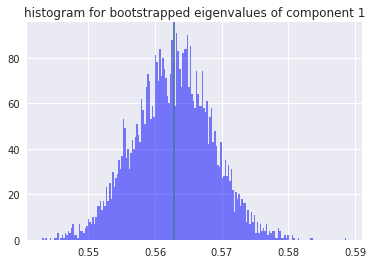

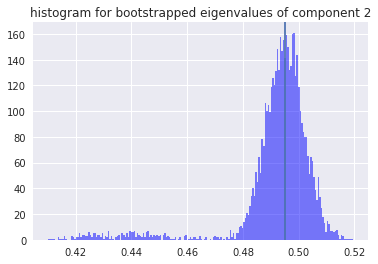

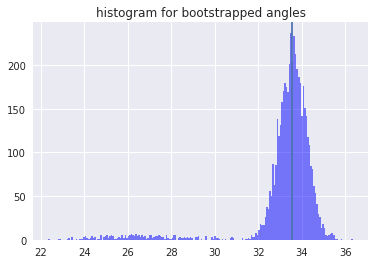

In [6]:
# Fit bivariate Gaussian on the original data and compute confidence intervals, error bars using bootstrapping

#Gaussian Mixture Model 
#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle = angle(eigvec1, eigvec2) # angle between the main eigenvectors 

# boostrapping
def bstr(data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """    
    perc_one = list() # hold proprtion of largest eigenvalues for component 1
    perc_two = list() # hold propotion of largest eigenvalues for component 2
    
    vec_one = list() # hold eigenvectors corresponding to largest eigenvalue for component 1
    vec_two = list() # hold eigenvectors corresponding to largest eigenvalue for component 2
    
    angles = list() # hold angle between main eigenvectors of two Gaussian component
    
    for i in range(n):
        # resample from the original data matrix
        resampled_mat = data[np.random.randint(0, data.shape[0])]
        
        for j in range(data.shape[0]-1):
            data_resample = data[np.random.randint(0, data.shape[0])]
            resampled_mat = np.vstack((resampled_mat, data_resample))
    
        assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        perc_one.append(eig_val1)
        perc_two.append(eig_val2)
        vec_one.append(eig_vec1)
        vec_two.append(eig_vec2)
        angles.append(angle(eig_vec1, eig_vec2))
        
        
    vec_one = np.mean(vec_one, axis=0)
    vec_two = np.mean(vec_two, axis=0)
    
    return perc_one, perc_two, vec_one, vec_two, angles

perc_one, perc_two, vec_one, vec_two, bstr_angle = bstr(data_mat)

# plot the histogram for eigenvalues and angles
num_bins = 200
itera = [perc_one, perc_two, bstr_angle]
for i in range(len(itera)):
    n, bins, patches = plt.hist(itera[i], num_bins, facecolor='blue', alpha=0.5)
    if i == 0:
        plt.title('histogram for bootstrapped eigenvalues of component 1')
        plt.axvline(x=eigval1)
    elif i == 1:
        plt.title('histogram for bootstrapped eigenvalues of component 2')
        plt.axvline(x=eigval2)
    else:
        plt.title('histogram for bootstrapped angles')
        plt.axvline(x=orig_angle)
    
    plt.show()
    plt.close()


# Angle between the main eigenvector of a Gaussian and the main principal component. Done for each of the two Gaussians. Used all 20 imputed sets.

In [7]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

P, D, Q = svd(data_mat)

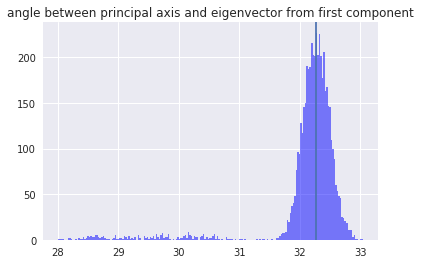

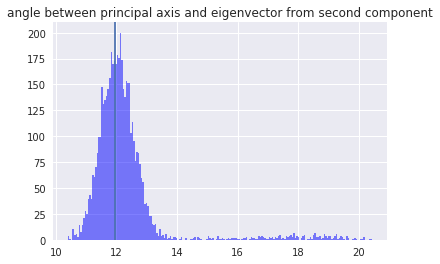

In [8]:
# boostrapping the angle between the principal component and the main eigenvectors of each component

#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle1 = angle(eigvec1, Q.T[:,0])
orig_angle2 = angle(eigvec2, Q.T[:,0])

def bstr(pc1, data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """            
    angle1 = list() # hold angle between main eigenvectors of two Gaussian component
    angle2 = list()
    
    for i in range(n):
        # resample from the original data matrix
        resampled_mat = data[np.random.randint(0, data.shape[0])]
        
        for j in range(data.shape[0]-1):
            data_resample = data[np.random.randint(0, data.shape[0])]
            resampled_mat = np.vstack((resampled_mat, data_resample))
    
        assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        angle1.append(angle(eig_vec1, pc1))
        angle2.append(angle(eig_vec2, pc1))
            
    return angle1, angle2

angle_first, angle_second = bstr(Q.T[:,0], data_mat)

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle_first, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from first component')
plt.axvline(x=orig_angle1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle_second, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from second component')
plt.axvline(x=orig_angle2)
plt.show()
plt.close()


# Angle between the main eigenvector of a Gaussian and the main principal component. Done for each of the two Gaussians. Used a single imputation for each data point of a polity by randomly selecting from the 20 imputed sets.

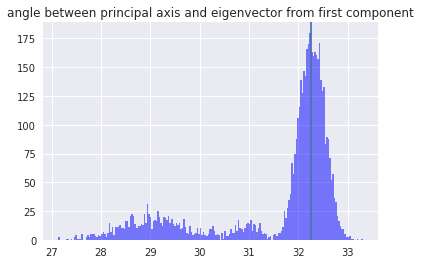

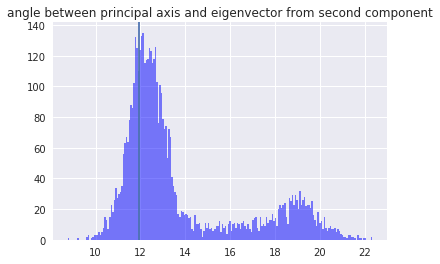

In [9]:
# bootstrap on single, random imputation 

#fit GMM
gmm = GMM(n_components=2).fit(data_mat)
orig_means = gmm.means_
orig_cov = gmm.covariances_
orig_weights = gmm.weights_

eigval1, eigval2, eigvec1, eigvec2 = weight_set(orig_means, orig_weights, orig_means, orig_cov)
orig_angle1 = angle(eigvec1, Q.T[:,0])
orig_angle2 = angle(eigvec2, Q.T[:,0])

def bstr(pc1, data, n=5000):
    """
    Given data matrix, perform bootstrapping by collecting n samples (default = 5000) and return the 
    error rate for the mean of the data. Assume that the given data matrix is numpy array
    """            
    angle1 = list() # hold angle between the PC and the main eigenvector for component1
    angle2 = list() # hold angle between the PC and the main eigenvector for component2
        
    for i in range(n):
        
        # resample from the original data matrix
        for j in range(414):
            ran_impute = np.random.randint(20)
            
            if j == 0: #first element 
                resampled_mat = data[j+ran_impute*414]
            else:
                resampled_mat = np.vstack((resampled_mat, data[j+ran_impute*414]))
        
        assert len(resampled_mat) == 414 # check if the resampled matrix has same dimension as data matrix
        
        gmm_resampled = GMM(n_components=2).fit(resampled_mat)
        gmm_weights = gmm_resampled.weights_
        gmm_cov = gmm_resampled.covariances_
        gmm_means = gmm_resampled.means_
        
        eig_val1, eig_val2, eig_vec1, eig_vec2 = weight_set(orig_means, orig_weights, gmm_means, gmm_cov, bstr=True)
        
        angle1.append(angle(eig_vec1, pc1))
        angle2.append(angle(eig_vec2, pc1))
            
    return angle1, angle2

angle_first, angle_second = bstr(Q.T[:,0], data_mat)

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle_first, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from first component')
plt.axvline(x=orig_angle1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle_second, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between principal axis and eigenvector from second component')
plt.axvline(x=orig_angle2)
plt.show()
plt.close()


# Bootstrap on the flow vectors within each Gaussian 


In [18]:
def gaussian_idx(data_mat):
    """
    Return index for data points that lie in one of the two Gaussians
    """
    #Gaussian Mixture Model 
    #fit GMM
    gmm = GMM(n_components=2).fit(data_mat)
    cov = gmm.covariances_
    prob_distr = gmm.predict_proba(data_mat)

    # determine to which of the two gaussians each data point belongs by looking at probability distribution 
    if gmm.weights_[0] < gmm.weights_[1]:
        gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
        gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]
    else:
        gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] <= prob_distr[i][1]]
        gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] <= prob_distr[j][0]]
    return gauss1_idx, gauss2_idx

# flow vectors for each NGAs
def flow_vec(ngas, data, data_idx):
    """
    Find the average of the flow vectors 
    """
    nga_dict = {key:list() for key in ngas}
    vec_coef1 = list() # coefficients for overall flow vectors for each ngas in the first gaussian
    vec_ic1 = list() # intercept for overall flow vectors for each ngas in the first gaussian
    vec_coef2 = list() # coefficients for overall flow vectors for each ngas in the second gaussian
    vec_ic2 = list() # intercept for overall flow vectors for each ngas in the second gaussian

    for idx in range(len(data)):
        nga = pnas_data1.loc[idx].NGA
        nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0], data_idx[idx]))            

    for i in range(len(ngas)):

        nga_pc_gauss1 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss1_idx]
        nga_pc_gauss2 = [[p,j] for p,j,_,t in nga_dict[ngas[i]] if t in gauss2_idx]

        nga_time1 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss1_idx])
        nga_time2 = np.asarray([k for _,_,k,t in nga_dict[ngas[i]] if t in gauss2_idx])
                 
        #fit linear regression vector
        if len(nga_time1) == 0:
            ols2 = linear_model.LinearRegression()
            model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)
                        
            vec_coef2.append(model2.coef_)
            vec_ic2.append(model2.intercept_)
            
        elif len(nga_time2) == 0:
            ols1 = linear_model.LinearRegression()      
            model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)

            vec_coef1.append(model1.coef_)
            vec_ic1.append(model1.intercept_)

        else:
            ols1 = linear_model.LinearRegression()
            model1 = ols1.fit(nga_time1.reshape(-1,1), nga_pc_gauss1)
            ols2 = linear_model.LinearRegression()
            model2 = ols2.fit(nga_time2.reshape(-1,1), nga_pc_gauss2)

            vec_coef1.append(model1.coef_)
            vec_ic1.append(model1.intercept_)
            vec_coef2.append(model2.coef_)
            vec_ic2.append(model2.intercept_)

    return np.asarray(vec_coef1), np.asarray(vec_ic1), np.asarray(vec_coef2), np.asarray(vec_ic2)

def avg_flow(vec_coef1, vec_ic1, vec_coef2, vec_ic2):
    """
    Given an array of coefficients and intercepts for each Gaussians, find the 
    average flow vector for each Gaussian and describe them with respect to x, y axis 
    (eliminating time)
    """
    # find the average coefficients and intercepts for each Gaussian
    gauss1_coef = np.mean(vec_coef1, axis=0)
    gauss1_ic = np.mean(vec_ic1, axis=0)
    gauss2_coef = np.mean(vec_coef2, axis=0)
    gauss2_ic = np.mean(vec_ic2, axis=0)

    gauss1_t = sorted(gauss1_time)
    gauss2_t = sorted(gauss2_time)
    ic1 = np.asarray([gauss1_ic]).T
    ic2 = np.asarray([gauss2_ic]).T

    def line_vec(time, coef, intercept):
        return [(coef*i+intercept) for i in time]
    
    gauss1 = line_vec(gauss1_t, gauss1_coef, ic1)
    gauss2 = line_vec(gauss2_t, gauss2_coef, ic2)

    gauss1_x= [i for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
    gauss1_y= [j for i,j in gauss1 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
    gauss2_x= [i for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]
    gauss2_y= [j for i,j in gauss2 if (i<=4 and i>=-6) and (j>=-3 and j<=3)]

    ols1 = linear_model.LinearRegression()
    model1= ols1.fit(gauss1_x, gauss1_y)
    ols2 = linear_model.LinearRegression()
    model2= ols2.fit(gauss2_x, gauss2_y)

    return model1.coef_, model2.coef_



In [85]:
def pl(n):
    np.random.seed()
    
    data_idx = dict()
    
    resample = np.random.randint(0, len(data), size=len(data))
    resampled_mat = data[resample]

    data_idx = dict(enumerate(resample.tolist()))
    
    assert resampled_mat.shape == data.shape # check if the resampled matrix has same dimension as data matrix

    first_coef, sec_coef = flow_vec(ngas, resampled_mat, data_idx)
    first_ang, sec_ang = np.arctan(first_coef[0][0]), np.arctan(sec_coef[0][0])
    
    return first_ang, sec_ang

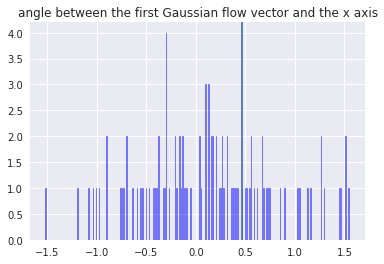

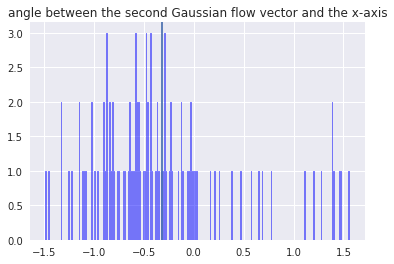

In [86]:
gauss1_idx, gauss2_idx = gaussian_idx(data_mat)
gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data
coef1, coef2 = flow_vec(ngas, data, {key:key for key in range(len(data))})
ang1, ang2 = np.arctan(coef1[0]), np.arctan(coef2[0])

def bstr_flow(ngas, data, n = 100):
    """
    Bootstrap the angle between the flow vectors and the x axis for each cluster
    """
#     angles = []

    p = Pool(os.cpu_count())
    results = p.map(pl, range(n))
    angle1, angle2 = zip(*results)
    
#     for i in range(n):
#         angles.append(p.apply_async(pl, args=()))
#     p.close()
#     p.join()
    
#     angles = [angle.get() for angle in angles]
#     angle1, angle2 = zip(*angles)
#     q = mp.Queue()
#     jobs = []
    
#     for i in range(n):
#         p = mp.Process(target = pl, args = (q,))
#         jobs.append(p)
#         p.start()
        
#     for p in jobs:
#         p.join()
#         pt.update()
        
#     while not q.empty():
#         a,b=q.get()
#         print('a', a, 'b',b)
#         angle1.append(a)
#         angle2.append(b)
#     angle1 = []; angle2 = []
    
#     for i in range(n):
#         ang1, ang2 = pl()
#         pt.update()
#         angle1.append(ang1); angle2.append(ang2)

    return angle1, angle2

angle1, angle2 = bstr_flow(ngas, data)

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle1, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the first Gaussian flow vector and the x axis')
plt.axvline(x=ang1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle2, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the second Gaussian flow vector and the x-axis')
plt.axvline(x=ang2)
plt.show()
plt.close()





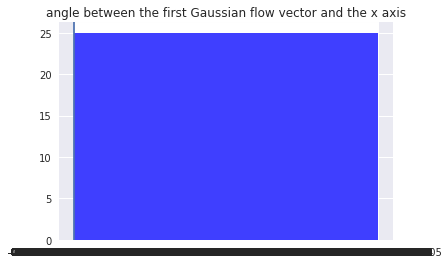

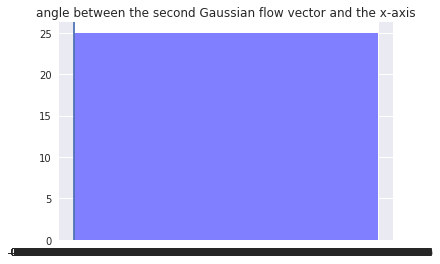

In [7]:
# histogram for above using the results from GPU
gauss1_idx, gauss2_idx = gaussian_idx(data_mat)
gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data
coef1, coef2 = flow_vec(ngas, data, {key:key for key in range(len(data))})
ang1, ang2 = np.arctan(coef1[0]), np.arctan(coef2[0])

angle1_path = os.path.abspath(os.path.join("./..","data","angle1.txt"))
angle2_path = os.path.abspath(os.path.join("./..","data","angle2.txt"))

with open(angle1_path) as f:
    angle1_content = f.readlines()
angle1 = [x.strip() for x in angle1_content]

with open(angle2_path) as f:
    angle2_content = f.readlines()
angle2 = [x.strip() for x in angle2_content]

angle1 = [float(i) for i in angle1]
angle2 = [float(i) for i in angle2]

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle1, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the first Gaussian flow vector and the x axis')
plt.axvline(x=ang1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle2, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the second Gaussian flow vector and the x-axis')
plt.axvline(x=ang2)
plt.show()
plt.close()

    

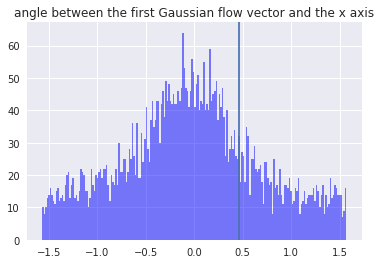

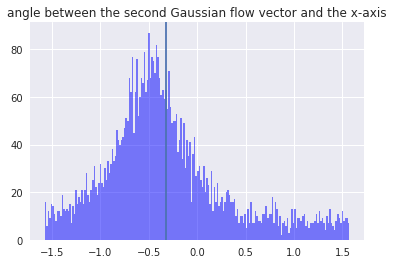

In [10]:
angle1 = [float(i) for i in angle1]
angle2 = [float(i) for i in angle2]

# plot the histogram for eigenvalues and angles
num_bins = 200

# angle between PC and the first component
n, bins, patches = plt.hist(angle1, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the first Gaussian flow vector and the x axis')
plt.axvline(x=ang1)
plt.show()
plt.close()

# angle between PC and the second component 
n, bins, patches = plt.hist(angle2, num_bins, facecolor='blue', alpha=0.5)
plt.title('angle between the second Gaussian flow vector and the x-axis')
plt.axvline(x=ang2)
plt.show()
plt.close()

    

average flow vector bootstrapping on NGAs: 100% ||             | Time:  0:14:59


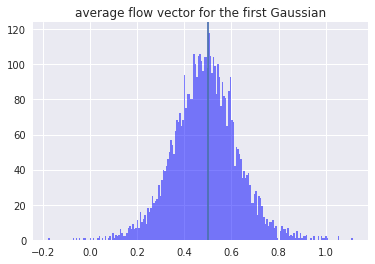

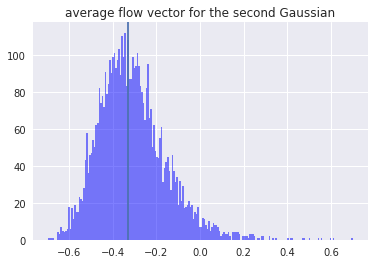

In [21]:
# resampling from flow vector of each NGAs 

pt = turchin.progress_timer(n_iter = 5000, description = 'average flow vector bootstrapping on NGAs')

# flow vectors for each NGAs
vec_coef1, vec_ic1, vec_coef2, vec_ic2 = flow_vec(ngas, data, {key:key for key in range(len(data))})
gauss_coef1, gauss_coef2 = avg_flow(vec_coef1, vec_ic1, vec_coef2, vec_ic2)

def bstr_nga_flow(vec_coef1, vec_ic1, vec_coef2, vec_ic2, n=5000):
    """
    Resample from the flow vector of each nga with respect to each clusters
    """
    flow_vec1 = []
    flow_vec2 = []
    
    for i in range(n):
        
        #first cluster
        resample1 = np.random.randint(0, len(vec_coef1), size = len(vec_coef1))
        resampled_coef1 = vec_coef1[resample1]
        resampled_ic1 = vec_ic1[resample1]
        
        #second cluster
        resample2 = np.random.randint(0, len(vec_coef2), size = len(vec_coef2))
        resampled_coef2 = vec_coef2[resample2]
        resampled_ic2 = vec_ic2[resample2]
        
        # find the average flow vector for each cluster
        coef1, coef2 = avg_flow(resampled_coef1, resampled_ic1, resampled_coef2, resampled_ic2)
        
        flow_vec1.append(coef1[0][0])
        flow_vec2.append(coef2[0][0])
        
        pt.update()
        
    return flow_vec1, flow_vec2

flow_vec1, flow_vec2 = bstr_nga_flow(vec_coef1, vec_ic1, vec_coef2, vec_ic2)
pt.finish()

# plot the histogram 
num_bins = 200

# average flow vector for the first Gaussian after bootstrapping
n, bins, patches = plt.hist(flow_vec1, num_bins, facecolor='blue', alpha=0.5)
plt.title('average flow vector for the first Gaussian')
plt.axvline(x=gauss_coef1[0][0])
plt.show()
plt.close()

# average flow vector for the second Gaussian after bootstrapping 
n, bins, patches = plt.hist(flow_vec2, num_bins, facecolor='blue', alpha=0.5)
plt.title('average flow vector for the second Gaussian')
plt.axvline(x=gauss_coef2[0][0])
plt.show()
plt.close()

    
    
